# Drifting Gratings
Organizing data by drifting gratings stimulus

Create manifest to keep track of data

In [10]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint

# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc = BrainObservatoryCache()

Following code block filters down to cells of interest (cells that are direction selective, show a significant response to drifitng gratings stim) 

In [11]:
import pandas as pd

# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

# find direction selective cells in VISp
visp_ec_ids = [ ec['id'] for ec in visp_ecs ]
visp_cells = cells[cells['experiment_container_id'].isin(visp_ec_ids)]
print("VISp cells: %d" % len(visp_cells))

# significant response to drifting gratings stimulus
sig_cells = visp_cells[visp_cells['p_dg'] < 0.05]
print("cells with sig. response to drifting gratings: %d" % len(sig_cells))

# direction selective cells
dsi_cells = sig_cells[(sig_cells['g_dsi_dg'] > 0.9)]
print("direction-selective cells: %d" % len(dsi_cells))


total cells: 63251


NameError: name 'visp_ecs' is not defined

Import stim info data

In [15]:
import allensdk.brain_observatory.stimulus_info as stim_info

# find experiment containers for those cells
dsi_ec_ids = dsi_cells['experiment_container_id'].unique()
print("total dsi experiment containers: %d" % len(dsi_ec_ids))

# Download the ophys experiments containing the drifting gratings stimulus for VISp experiment containers
dsi_exps = boc.get_ophys_experiments(experiment_container_ids=dsi_ec_ids, stimuli=[stim_info.DRIFTING_GRATINGS])
print("VISp drifting gratings ophys experiments: %d" % len(dsi_exps))

total dsi experiment containers: 22
VISp drifting gratings ophys experiments: 22


Import required packages for code

In [18]:
from matplotlib import pyplot as plt
#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import cmath

def plot_stimulus_table(stim_table, title):
    fstart = stim_table.start.min()
    fend = stim_table.end.max()
    
    fig = plt.figure(figsize=(15,1))
    ax = fig.gca()
    for i, trial in stim_table.iterrows():    
        x1 = float(trial.start - fstart) / (fend - fstart)
        x2 = float(trial.end - fstart) / (fend - fstart)            
        ax.add_patch(patches.Rectangle((x1, 0.0), x2 - x1, 1.0, color='r'))
    ax.set_xticks((0,1))
    ax.set_xticklabels((fstart, fend))
    ax.set_yticks(())
    ax.set_title(title)
    ax.set_xlabel("frames")


 FUNCTIONS

In [2]:
# plot_dg(freq, ori, dsi_cell, data_set, print_graphs, plot_stim_instances, plot_avg_graph, plot_trial_on_avg, 
# freq_ind, ori_ind, axs): calculates average dff for a single type of stim. 
#
#
#
#
# freq: temporal frequency of stimulus
# ori: orientation of stimulus
# dsi_cell: NWB file for cell
# data_set:  ophys experiment data
# print_graphs: boolean value, if true, plots all of the 15 trials for each stim
# plot_stim_instances: boolean value, if true, shows a plot of the frames each stim is shown
# plot_avg_graph: boolean value, if true, shows average plot of each stim
# plot_trial_on_avg: boolean value, if true, shows trial plots on same plot as avg
# ori_ind: indice of orientation axis for subplots
# freq_ind: indice of frequency axis for subplots
# axs: subplot object
def plot_dg(freq, ori, dsi_cell, data_set, print_graphs, plot_stim_instances, plot_avg_graph, plot_trial_on_avg, 
            freq_ind, ori_ind, axs):
    
    # get flourescence traces for target cell
    dsi_cell_id = dsi_cell['cell_specimen_id']
    time, f_traces = data_set.get_corrected_fluorescence_traces(cell_specimen_ids=[dsi_cell_id])
    
    # this is a pandas DataFrame. find trials with a given stimulus condition.
    # 40 diff total conditions
    temporal_frequency = freq
    orientation = ori
    stim_table = data_set.get_stimulus_table('drifting_gratings')
    stim_table = stim_table[(stim_table.temporal_frequency == temporal_frequency) & 
                            (stim_table.orientation == orientation)]
    
    # plot of instances of stimulus frames
    if (plot_stim_instances) :
        plot_stimulus_table(stim_table, "Instances of Stimuli, TF %d ORI %d" % (temporal_frequency, orientation))
        plt.show()
    
    # make 2D array of 120 data points of f_traces and dff_traces for each of the 15 trials
    all_f_traces = [[0]*120 for i in range(15)] 
    dff_traces = [[0]*120 for i in range(15)] 
    x=0
    
    # plot 15 trial graphs
    # initialize trial graph subplots
    if (print_graphs):
        fig_trial, axs_trial = plt.subplots(3, 5, sharey=True, figsize=(10,10))
        fig_trial.suptitle("15 Trials for Stimuli, TF %d ORI %d" % (temporal_frequency, orientation))
    x_ind = 0 
    y_ind = 0
    
    for start_ind in stim_table.start:
        
        all_f_traces[x] = f_traces[0][start_ind-30:start_ind+90] # get f_traces at desired indices
        F0 = np.mean(f_traces[0][start_ind-30:start_ind]) # calculate baseline as the preceding second before stim
        dff_traces[x] = (all_f_traces[x]-F0)/F0  # calculate dff at desired indices
        
        if (plot_avg_graph and plot_trial_on_avg) :
            axs[freq_ind, ori_ind].plot(time[0:120]-time[0]-1, dff_traces[x], color='tan')
        if (print_graphs) :
            axs_trial[x_ind, y_ind].plot(time[0:120]-time[0]-1, dff_traces[x], color='tan')
            axs_trial[x_ind, y_ind].set_title("Frames %d to %d" % (start_ind-30,start_ind+90),
                                              fontdict = {'fontsize': 7})

            # Mark the area of the stimulus
            axs_trial[x_ind, y_ind].fill_between(time[0:60]-time[0], min(dff_traces[x]), 
                                                                         min(dff_traces[x])+0.005,
                facecolor="orange", # The fill color
                color='blue',       # The outline color
                alpha=0.4)          # Transparency of the fill
            
            for ax in axs_trial.flat:
                ax.set(xlabel='sec', ylabel='dF/F')
            for ax in axs_trial.flat:
                ax.label_outer()

            y_ind +=1 
            if (y_ind > 4) : 
                y_ind = 0
                x_ind +=1
        
        x+=1
    
    # calculate and plot the average response of all graphs
    mean_dff = np.mean(dff_traces, axis=0)
    
    if (plot_avg_graph) :
        axs[freq_ind,ori_ind].plot(time[0:120]-time[0]-1,mean_dff, color='black')
        axs[freq_ind,ori_ind].set_title("TF %d ORI %d" %(temporal_frequency, orientation))
        axs[freq_ind,ori_ind].fill_between(time[0:60]-time[0], 
                min(mean_dff), min(mean_dff)+0.005,
                facecolor="orange", # The fill color
                color='blue',       # The outline color
                alpha=0.4)          # Transparency of the fill
    
    # calculate single value average dff from average graph
    return np.mean(mean_dff[30:90])
    
    

In [12]:
# dg_for_cell(index, plot_trial_graphs, plot_stim_instances, plot_avg_graph, plot_trial_on_avg, show_text) : given
# a cell index, will calculate and return Rmax, pref TF, pref ORI, Rorth, OSI and gOSI values. Will print 
# metadata, avg response graphs for each kind of stim, and trial graphs if desired. 
# 
#
#
# boc : manifest that keeps track of downloaded data
# dsi_cells: object containing all direction selective cells in given brain region
# index: index of cell in vector of filtered direction selective cells. There are 1159 direction selective cells. 
# Index values can range from 0 to 1158
# plot_trial_graphs: boolean value, if true, shows all of the 15 trials for each stim
# plot_stim_instances: boolean value, if true, shows a plot of the frames each stim is shown
# plot_avg_graph: boolean value, if true, shows average plot of each stim
# plot_trial_on_avg: boolean value, if true, shows trial plots on same plot as avg
# show_text: boolean value, if true, prints text information such as cell metadata, stimulus matrix,
# and outputs of analysis calculations
# Warning- calling this function will require downloading the ophys experiment data, which may take some time
# This function downloads the NWB files that contain the fluorescence traces for segmented cells in 
# those experiments that used the dg stim
def dg_for_cell(boc, dsi_cells, index, plot_trial_graphs, plot_stim_instances, plot_avg_graph, plot_trial_on_avg, 
                show_text): 
    
    # pick a direction-selective cell and find its NWB file
    dsi_cell = dsi_cells.iloc[index]
    
    # figure out which ophys experiment has the drifting gratings stimulus for that cell
    cell_exp = boc.get_ophys_experiments(cell_specimen_ids=[dsi_cell['cell_specimen_id']],
                                         stimuli=[stim_info.DRIFTING_GRATINGS])[0]

    data_set = boc.get_ophys_experiment_data(cell_exp['id'])
    
    if (show_text):
        print("Metadata from NWB file:")
        pprint.pprint(data_set.get_metadata())
    
    # initialize stim_matrix
    stim_matrix = [[0]*8 for i in range(5)]
    
    # initialize avg graph subplots
    if (plot_avg_graph) :
        fig, axs = plt.subplots(5, 8, sharey=True, figsize=(15,15))
        fig.suptitle('Average Fluorescence For Each Stim')
        for ax in axs.flat:
            ax.set(xlabel='sec', ylabel='dF/F')
        for ax in axs.flat:
            ax.label_outer()
    else :
        axs = None 
        
    # make avg graph subplots and calculate average dff for each stim
    freq_array = [1,2,4,8,15]
    ori_array = [0,45,90,135,180,225,270,315]
    freq_ind = 0
    for freq in freq_array :
        ori_ind = 0
        for ori in ori_array :
            avg_dff = plot_dg(freq, ori, dsi_cell, data_set, plot_trial_graphs, plot_stim_instances, 
                              plot_avg_graph, plot_trial_on_avg, freq_ind, ori_ind, axs)
            stim_matrix[freq_ind][ori_ind] = avg_dff
            ori_ind +=1
        freq_ind += 1
    
    # print stim_matrix
    row_labels = ['1', '2', '4', '8', '15']
    column_labels = ['0','45','90','135','180','225','270','315']
    if (show_text):
        print(pd.DataFrame(stim_matrix, columns=column_labels, index=row_labels))
    
    # calc R max val in stim_matrix
    Rmax = np.amax(stim_matrix)
    if (show_text): print("Cell has Rmax of %f" % Rmax)
    result = np.where(stim_matrix == np.amax(stim_matrix))
    max_coor = list(zip(result[0], result[1]))
    if (show_text): print("At temporal frequency of %d and orientation of %d" % 
          (freq_array[max_coor[0][0]], ori_array[max_coor[0][1]]))
    
    # calc R orth
    Rorth = (stim_matrix[max_coor[0][0]][max_coor[0][1]-2] + stim_matrix[max_coor[0][0]][(max_coor[0][1]+2)%8])/2
    if (show_text): print("Rorth: %f" % Rorth)
    
    # calc OSI
    OSI = (Rmax - Rorth)/(Rmax + Rorth)
    if (show_text): print("OSI: %f" % OSI)
    
    # calc gOSI
    Rtheta=0
    Rtheta_exp=0
    for i in range(0, 8) :
        Rtheta += stim_matrix[max_coor[0][0]][i]
        Rtheta_exp += (Rtheta * cmath.exp(complex(0,2)*ori_array[i]))
    gOSI = abs(Rtheta_exp/Rtheta)
    if (show_text): print("gOSI: %f" % gOSI)
    
    # return array of Rmax, pref TF, pref ORI, Rorth, OSI and gOSI values
    return [Rmax, freq_array[max_coor[0][0]], ori_array[max_coor[0][1]], Rorth, OSI, gOSI]
    

In [13]:
# create_histogram(targeted_struct): creates histogram of OSI of all cells in desired cortical layer
# 
#
#
#
# targeted_struct: string argument identifying desired cortical layer. Options are
# 'VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl'. Higher order visual cortices (VISam, VISpm, VISrl) show
# decreased activity with increased running speed
# print_OSIs: when set to true, will print the OSIs for each cell
# print_other_vals: when set to true, will print the Rmax, pref TF, pref ORI, Rorth, and gOSI
# filter_vals: when set to true, creates the histogram and excludes OSIs below 0 or above 2
#
# Warning: will require downloading nwb files for many cells. Will take a while 
def create_histogram(targeted_struct, print_OSIs, print_other_vals, filter_vals) :
    
    # Download experiment containers for experiments of target structure
    exp_containers = boc.get_experiment_containers(targeted_structures=[targeted_struct])
    print("all %s experiment containers: %d" % (targeted_struct, len(exp_containers)))
    
    # Download cells for a set of experiments and convert to DataFrame
    cells = boc.get_cell_specimens() # this code may be moved outside of the function?
    cells = pd.DataFrame.from_records(cells)
    print("total cells: %d" % len(cells))

    # find direction selective cells in VISp
    exp_container_ids = [ ec['id'] for ec in exp_containers ]
    structure_cells = cells[cells['experiment_container_id'].isin(exp_container_ids)]
    print("%s cells: %d" % (targeted_struct, len(structure_cells)))

    # significant response to drifting gratings stimulus
    sig_cells = structure_cells[structure_cells['p_dg'] < 0.05]
    print("cells with sig. response to drifting gratings: %d" % len(sig_cells))

    # direction selective cells
    dsi_cells = sig_cells[(sig_cells['g_dsi_dg'] > 0.9)]
    print("direction-selective cells: %d" % len(dsi_cells))

    OSIs = [0] * len(dsi_cells)
    OSI_index=0
    index = 0
    
    while index < len(dsi_cells) :
        cell_vals = dg_for_cell(boc, dsi_cells, index, False, False, False, False, False)
        OSI = cell_vals[4]
        OSIs[OSI_index] = OSI
        if (print_OSIs) : print(index, "OSI:", OSI)
        if (print_other_vals) : 
            print("Rmax:", cell_vals[0])
            print("Pref TF:", cell_vals[1])
            print("Pref ORI:", cell_vals[2])
            print("Rorth:", cell_vals[3])
            print("gOSI:", cell_vals[5])
            
        index += 1
        OSI_index += 1
    
    if(filter_vals):
        filtered_OSIs = filter(lambda tar_OSI: 0 <= tar_OSI <= 2, OSIs)
        OSIs_to_plot = filtered_OSIs
    else :
        OSIs_to_plot = OSIs
        
    plt.hist(list(OSIs_to_plot), 50, density = 1)
    if (filter_vals): plt.title("Distribution of OSI values for all cells in %s (after filtering)" % targeted_struct)
    else : plt.title("Distribution of OSI values for all cells in %s (prior to filtering)" % targeted_struct)
    plt.xlabel('Orientation Selectivity Index for Drifting Gratings')
    plt.ylabel('Number of Cells')
    

TESTS

In [16]:
# This function downloads the NWB files that contain the fluorescence traces for segmented cells in 
# those experiments that used the dg stim
 # Download experiment containers for experiments of target structure
targeted_struct = 'VISam'
exp_containers = boc.get_experiment_containers(targeted_structures=[targeted_struct])
print("all %s experiment containers: %d" % (targeted_struct, len(exp_containers)))

# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens() # this code may be moved outside of the function?
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

# find direction selective cells in VISp
exp_container_ids = [ ec['id'] for ec in exp_containers ]
structure_cells = cells[cells['experiment_container_id'].isin(exp_container_ids)]
print("%s cells: %d" % (targeted_struct, len(structure_cells)))

# significant response to drifting gratings stimulus
sig_cells = structure_cells[structure_cells['p_dg'] < 0.05]
print("cells with sig. response to drifting gratings: %d" % len(sig_cells))

# direction selective cells
dsi_cells = sig_cells[(sig_cells['g_dsi_dg'] > 0.9)]
print("direction-selective cells: %d" % len(dsi_cells))

cellInfo = dg_for_cell(boc, dsi_cells, 56, False, False, False, True, True)


all VISam experiment containers: 38
total cells: 63251
VISam cells: 3569
cells with sig. response to drifting gratings: 1241
direction-selective cells: 57
Metadata from NWB file:
{'age_days': 119,
 'cre_line': 'Cux2-CreERT2/wt',
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.2',
 'excitation_lambda': '910 nanometers',
 'experiment_container_id': 701048110,
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt',
 'imaging_depth_um': 175,
 'indicator': 'GCaMP6f',
 'ophys_experiment_id': 707006626,
 'pipeline_version': '3.0',
 'session_start_time': datetime.datetime(2018, 6, 7, 15, 44, 15),
 'session_type': 'three_session_A',
 'sex': 'male',
 'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-382421',
 'targeted_structure': 'VISam'}
           0        45        90       135       180       225       270  \
1  -0.075369  0.022694 -0.055013 -0.079711 -0.015016  0.015391 -0.011299   
2  -0.050854  0.015057 -0.03

all VISam experiment containers: 38
total cells: 63251
VISam cells: 3569
cells with sig. response to drifting gratings: 1241
direction-selective cells: 57
0 OSI: 1.0162593923384606
1 OSI: -1.9606243576501983
2 OSI: 3.2563306254032636
3 OSI: 7.936599118508852
4 OSI: 3.4357552031426715
5 OSI: 2.1095841628729084
6 OSI: 4.180485730250983
7 OSI: 1.2989270869947647
8 OSI: 1.6630685404718686
9 OSI: 1.382912817441397
10 OSI: 1.084599655492004
11 OSI: 1.09296803534759
12 OSI: 1.6895293948428434
13 OSI: 1.13395379377302
14 OSI: 1.0890138066434214
15 OSI: 1.1936333731575195
16 OSI: 1.6297488165537455
17 OSI: 2.289802241112385
18 OSI: -1.0792005623655305
19 OSI: 11.929297361236747
20 OSI: -1.0929155601620884
21 OSI: 1.2650201125166525
22 OSI: -10.725079208181203
23 OSI: 3.448053653773752
24 OSI: 2.4346977222005486
25 OSI: 2.0243827616030647
26 OSI: 7.13674762207323
27 OSI: 0.9935320960925043
28 OSI: 3.242719759476858
29 OSI: 1.4944276436066908
30 OSI: 1.193645418658242
31 OSI: -1.0311004660156828


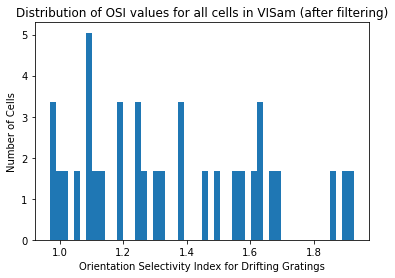

In [141]:
create_histogram('VISam', True, False, True)

In [ ]:
create_histogram('VISpm', True, False, True)

Run to see data analysis done by the Allen Institute (peak response, OSI, gOSI, etc.) 

In [17]:
dsi_cell = dsi_cells.iloc[15]
print("Peak dff: Allen %0.3f" % dsi_cell.peak_dff_dg, "vs. est %0.3f" % (cellInfo[0]*100))
print("Pref dir: Allen %0.f" % dsi_cell.pref_dir_dg, "vs. est %0.f" % cellInfo[2])
print("Pref tf: Allen %0.f" % dsi_cell.pref_tf_dg, "vs. est %0.f" % cellInfo[1])
print("OSI: Allen %.2f" % dsi_cell.osi_dg, "vs. est %.2f" % cellInfo[4])

Peak dff: Allen 1.533 vs. est 1.533
Pref dir: Allen 0 vs. est 0
Pref tf: Allen 1 vs. est 1
OSI: Allen 1.28 vs. est 1.28
